## App review classification using DistilBERT model 

### Import the necessary libraries

In [1]:
import transformers
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


C:\Users\alpya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the Dataset

In [2]:
df = pd.read_csv('randomized_balanced.csv')
df.head()

,review,label
0,Seems more transparent & meaningful issues.,rating
1,The best app for editing texts,rating
2,It seems like it would be a great addition to ...,feature request
3,Its really fun and any age can play it and enj...,user experience
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report


## Start of Preprocessing

In [3]:
df['count'] = df['review'].apply(lambda x: len(x.split()))# encode the class labels
df.head()

,review,label,count
0,Seems more transparent & meaningful issues.,rating,6
1,The best app for editing texts,rating,6
2,It seems like it would be a great addition to ...,feature request,27
3,Its really fun and any age can play it and enj...,user experience,20
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report,43


### Get the number of word distrubution in the dataset

<Figure size 800x800 with 0 Axes>

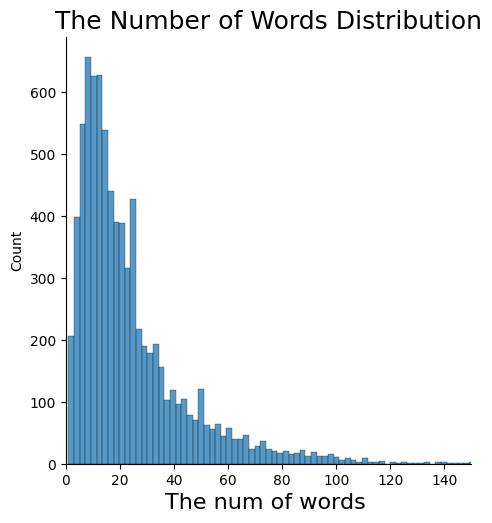

In [4]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 150)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

### Assign a Unique Integer for each target Class

In [5]:
df['encoded_text'] = df['label'].astype('category').cat.codes # encode the class labels

df.head(10)

,review,label,count,encoded_text
0,Seems more transparent & meaningful issues.,rating,6,2
1,The best app for editing texts,rating,6,2
2,It seems like it would be a great addition to ...,feature request,27,1
3,Its really fun and any age can play it and enj...,user experience,20,3
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report,43,0
5,Good app really really Best app Thanks Faceboo...,rating,9,2
6,I think we should get more.,feature request,6,1
7,No option for dark mode on my Motorola g5 stylus,feature request,10,1
8,atomic_number_53 gave it a 4 star because I co...,bug report,19,0
9,"Not what it use to be, too many ads. Not enoug...",user experience,47,3


### Convert the reviews and labels to lists for further processing

In [6]:
data_texts = df['review'].to_list()

data_labels = df['encoded_text'].to_list()

### Split the data into training, validation, and testing sets


In [7]:
train_texts, temp_data, train_labels, temp_labels = train_test_split(data_texts, data_labels, test_size = 0.5, random_state = 0)
val_texts, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state= 0)

### Initialize the Tokenizer and tokenize the training, validation and test reviews

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation = True, padding = True, max_length =128  )

val_encodings = tokenizer(val_texts, truncation = True, padding = True, max_length =128 )

test_encodings = tokenizer(test_data, truncation = True, padding = True, max_length =128 )

### Convert Tokenized encodings into TensorFlow datasets

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).batch(8)


val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(8)

### Initialize the DistilBERT model

In [10]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

## Train the model

In [11]:
# Model compilation with custom parameters
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=tf.metrics.SparseCategoricalAccuracy())

# Model training on the training set
model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5

500/500 [==============================] - 464s 910ms/step - loss: 0.9931 - sparse_categorical_accuracy: 0.6093 - val_loss: 0.7108 - val_sparse_categorical_accuracy: 0.7385
Epoch 2/5
500/500 [==============================] - 342s 684ms/step - loss: 0.5439 - sparse_categorical_accuracy: 0.8060 - val_loss: 0.6159 - val_sparse_categorical_accuracy: 0.7800
Epoch 3/5
500/500 [==============================] - 339s 678ms/step - loss: 0.3202 - sparse_categorical_accuracy: 0.8992 - val_loss: 0.5928 - val_sparse_categorical_accuracy: 0.8080
Epoch 4/5
500/500 [==============================] - 337s 674ms/step - loss: 0.1901 - sparse_categorical_accuracy: 0.9505 - val_loss: 0.5994 - val_sparse_categorical_accuracy: 0.8295
Epoch 5/5
500/500 [==============================] - 345s 690ms/step - loss: 0.1186 - sparse_categorical_accuracy: 0.9685 - val_loss: 0.6526 - val_sparse_categorical_accuracy: 0.8295


### Evaluate the model on the test set

In [16]:
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(8)

# Evaluate the model with the properly formatted test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print("Evaluation Results:", test_loss, test_acc)


250/250 [==============================] - 38s 150ms/step - loss: 0.6171 - sparse_categorical_accuracy: 0.8310
Evaluation Results: 0.6171329021453857 0.8309999704360962


### Make predictions on the test set and print the classification report

In [19]:
# Perform prediction
predictions = model.predict(test_dataset)

# Use the logits attribute from the output
predicted_labels = np.argmax(predictions.logits, axis=1)

# Now calculate the metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average=None)  
recall = recall_score(test_labels, predicted_labels, average=None)  
f1 = f1_score(test_labels, predicted_labels, average=None)  

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

250/250 [==============================] - 38s 151ms/step
Accuracy: 0.831
Precision: [0.76935484 0.86163522 0.86403509 0.85011186]
Recall: [0.94455446 0.79343629 0.81069959 0.77393075]
F1 Score: [0.848      0.82613065 0.83651805 0.81023454]
